<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/edmar_rodrigues/Edmar_Rodrigues_Filho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = "Edmar Rodrigues Filho"

print(f'Meu nome é {nome}')

Meu nome é Edmar Rodrigues Filho


In [2]:
!nvidia-smi

Thu May  5 20:58:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    57W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [4]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

## Download do CIFAR-10

In [6]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [7]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [8]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

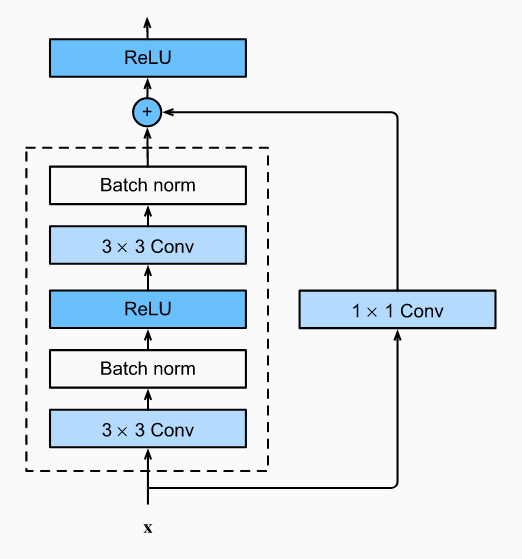

In [9]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        


    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out = out + self.downsample(x)

        out = self.relu(out)
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [10]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10. O modelo deve ter dois blocos básicos da Resnet.

In [11]:
from collections import OrderedDict
class Net(torch.nn.Module):
    def __init__(self, inplanes=2, planes=3):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.block1 = MyBasicBlock(inplanes=3, planes=32)
        self.block2 = MyBasicBlock(inplanes=32, planes=64)

        self.pool = nn.MaxPool2d(3,3)
        
        self.dense_in = 64*3*3
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(self.dense_in, 64)),
            ('relu1',  nn.ReLU()),
            ('dense2', nn.Linear(64, 10)),
        ]))

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.block1(x)
        out = self.pool(out)
        # print(out.shape)
        out = self.block2(out)
        out = self.pool(out)
        # print(out.shape)
        out= out.view(-1, self.dense_in)
        out = self.dense_layer(out)
        return out

In [12]:
# x,y = next(iter(train_dataloader))
# model = Net()
# model(x)

## Treinamento

### Definição dos hiperparâmetros

In [13]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
from tqdm import tqdm
def evaluation(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in tqdm(train_dataloader, total=len(train_dataloader), desc='Evaluating'):
      x = x.to(device)
      y = y.to(device)
      outputs = model(x)

      correct += (y == outputs.argmax(dim=1)).sum().item()
      total += x.shape[0]
          
    mean_accuracy = correct/total
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [22]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.85it/s]


Accuracy: 0.0838


Training: 100%|██████████| 800/800 [00:29<00:00, 26.69it/s]


Epoch: 0/19 Loss: 1.22507905960083


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.97it/s]


Accuracy: 0.584425


Training: 100%|██████████| 800/800 [00:29<00:00, 26.85it/s]


Epoch: 1/19 Loss: 0.9016761779785156


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.88it/s]


Accuracy: 0.68525


Training: 100%|██████████| 800/800 [00:29<00:00, 26.88it/s]


Epoch: 2/19 Loss: 0.9800982475280762


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.87it/s]


Accuracy: 0.705525


Training: 100%|██████████| 800/800 [00:29<00:00, 26.88it/s]


Epoch: 3/19 Loss: 0.7391338348388672


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.86it/s]


Accuracy: 0.7483


Training: 100%|██████████| 800/800 [00:29<00:00, 27.05it/s]


Epoch: 4/19 Loss: 0.4759123921394348


Evaluating: 100%|██████████| 800/800 [00:16<00:00, 47.21it/s]


Accuracy: 0.756625


Training: 100%|██████████| 800/800 [00:29<00:00, 26.98it/s]


Epoch: 5/19 Loss: 0.6209332942962646


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.31it/s]


Accuracy: 0.78745


Training: 100%|██████████| 800/800 [00:29<00:00, 26.98it/s]


Epoch: 6/19 Loss: 0.8071807622909546


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.93it/s]


Accuracy: 0.7929


Training: 100%|██████████| 800/800 [00:29<00:00, 26.94it/s]


Epoch: 7/19 Loss: 0.6890695691108704


Evaluating: 100%|██████████| 800/800 [00:16<00:00, 47.14it/s]


Accuracy: 0.778975


Training: 100%|██████████| 800/800 [00:29<00:00, 26.86it/s]


Epoch: 8/19 Loss: 0.4473879337310791


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.26it/s]


Accuracy: 0.820825


Training: 100%|██████████| 800/800 [00:29<00:00, 26.85it/s]


Epoch: 9/19 Loss: 0.44344836473464966


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.72it/s]


Accuracy: 0.872525


Training: 100%|██████████| 800/800 [00:29<00:00, 26.94it/s]


Epoch: 10/19 Loss: 0.6036372184753418


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.45it/s]


Accuracy: 0.868925


Training: 100%|██████████| 800/800 [00:29<00:00, 26.73it/s]


Epoch: 11/19 Loss: 0.31635403633117676


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.11it/s]


Accuracy: 0.8806


Training: 100%|██████████| 800/800 [00:29<00:00, 26.86it/s]


Epoch: 12/19 Loss: 0.44142040610313416


Evaluating: 100%|██████████| 800/800 [00:16<00:00, 47.08it/s]


Accuracy: 0.77405


Training: 100%|██████████| 800/800 [00:29<00:00, 27.04it/s]


Epoch: 13/19 Loss: 0.2378096729516983


Evaluating: 100%|██████████| 800/800 [00:16<00:00, 47.13it/s]


Accuracy: 0.8619


Training: 100%|██████████| 800/800 [00:29<00:00, 26.82it/s]


Epoch: 14/19 Loss: 0.25534728169441223


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.05it/s]


Accuracy: 0.89485


Training: 100%|██████████| 800/800 [00:29<00:00, 26.68it/s]


Epoch: 15/19 Loss: 0.4876653552055359


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.61it/s]


Accuracy: 0.877325


Training: 100%|██████████| 800/800 [00:30<00:00, 26.61it/s]


Epoch: 16/19 Loss: 0.28977227210998535


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.55it/s]


Accuracy: 0.892175


Training: 100%|██████████| 800/800 [00:29<00:00, 26.88it/s]


Epoch: 17/19 Loss: 0.5200769901275635


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.06it/s]


Accuracy: 0.9282


Training: 100%|██████████| 800/800 [00:29<00:00, 26.87it/s]


Epoch: 18/19 Loss: 0.35551372170448303


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.40it/s]


Accuracy: 0.900675


Training: 100%|██████████| 800/800 [00:29<00:00, 26.86it/s]


Epoch: 19/19 Loss: 0.09560799598693848


Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.64it/s]

Accuracy: 0.941


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

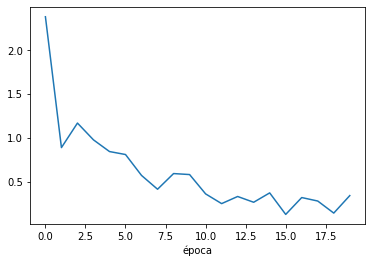

In [23]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [24]:
evaluation(model=model, loader=test_dataloader)

Evaluating: 100%|██████████| 800/800 [00:17<00:00, 46.89it/s]

Accuracy: 0.941


# Bonus Opcional

## Implementando o Dropout

In [25]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.
        self.p = p

    def forward(self, x, training: bool):
        # Escreva seu código aqui.

        if training:
          p_tensor = torch.ones(x.shape)*p
          bernoulli_tensor = torch.bernoulli(p_tensor)
          out = x*bernoulli_tensor
        else:
          out = x
        return out

    def __call__(self, x, training:bool):
      return self.forward(x, training)

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [26]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.50054931640625
mean zeros pytorch: 0.4968465268611908
